# Simulation 1: Two-dimensional Gaussian Mixture

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

## Random Feature

In [6]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        return result.T

## Problem setup

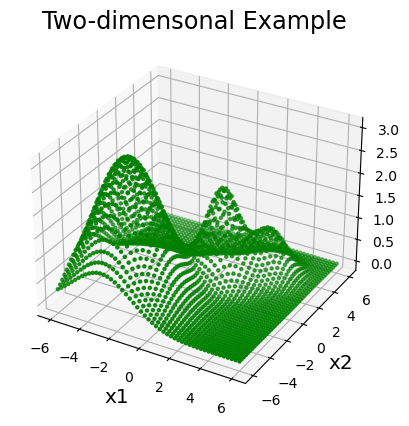

In [7]:
# binary Gaussian
def Gaussian(x, y, x0, y0, sigma):
    return np.exp(-((x - x0)**2 + (y - y0)**2) / (2.0 * sigma**2))

# parameter
x, y = np.meshgrid(np.linspace(-6, 6), np.linspace(-6, 6))

# calcalation
z = 3*Gaussian(x, y, -3, -3, 2)+2*Gaussian(x, y, 1, 1, 1)+Gaussian(x,y,3,3,1)

# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(x,y,z,marker=".",color="green")
plt.title("Two-dimensonal Example",fontsize="xx-large")
plt.xlabel('x1',fontsize="x-large")
plt.ylabel('x2',fontsize="x-large")
plt.show()

data generation

In [8]:
np.random.seed(0)
data=12*np.random.rand(5000,2)-6
noise=0.01*np.random.randn(5000)
x=data.T[0]
y=data.T[1]
z = 3*Gaussian(x, y, -3, -3, 2)+2*Gaussian(x, y, 1, 1, 1)+Gaussian(x,y,3,3,1)+noise

In [9]:
train_x=data
train_y=z
nntrain_x = torch.from_numpy(train_x).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## NN

In [10]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    dnn_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {dnn_trainloss[-1]}
            ''')
    
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.5955221468990118
            
epoch 100
            Train set - loss: 0.07669087894712755
            
epoch 200
            Train set - loss: 0.020593208426593235
            
epoch 300
            Train set - loss: 0.005841183867064041
            
epoch 400
            Train set - loss: 0.0038507444133800348
            
epoch 500
            Train set - loss: 0.003330825461257018
            
epoch 600
            Train set - loss: 0.003090785759985863
            
epoch 700
            Train set - loss: 0.0029605032177215484
            
epoch 800
            Train set - loss: 0.0028735681732697097
            
epoch 900
            Train set - loss: 0.002781950246098403
            
DNN complexity and model fitted in 96.837 s


In [11]:
dnn_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    dnn_x0 = dnn_x0.to(device)
    dnn_pred = net(dnn_x0)
    print(np.array(dnn_pred).reshape(-1))

[0.6863722  1.615499   0.3559559  ... 0.5124652  0.06629363 0.0205223 ]


# MLK

In [27]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

rff1=RandomFourierFeature(2,32,kernel='G',gamma=1)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=2)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=-0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.5085999979722541
            
epoch 100
            Train set - loss: 0.012414980134550667
            
epoch 200
            Train set - loss: 0.005841809075664946
            
epoch 300
            Train set - loss: 0.0038855266294923665
            
epoch 400
            Train set - loss: 0.0029139964486807673
            
epoch 500
            Train set - loss: 0.002347777031974866
            
epoch 600
            Train set - loss: 0.001971310793782249
            
epoch 700
            Train set - loss: 0.0017006485955784584
            
epoch 800
            Train set - loss: 0.0014981385535342486
            
epoch 900
            Train set - loss: 0.0013383439053316665
            
KernelNet complexity and model fitted in 99.843 s


In [28]:
kernel_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    kernel_x0 = kernel_x0.to(device)
    kernel_pred = net(kernel_x0)
    print(np.array(kernel_pred).reshape(-1))

[0.5869285  1.6911025  0.36275896 ... 0.46205926 0.0625968  0.01924974]


In [29]:
##calibration set
np.random.seed(1)
calibration_x=12*np.random.rand(5000,2)-6
cx=calibration_x.T[0]
cy=calibration_x.T[1]
calibration_noise=0.01*np.random.randn(5000)
calibration_y=3*Gaussian(cx, cy, -3, -3, 2)+2*Gaussian(cx, cy, 1, 1, 1)+Gaussian(cx,cy,3,3,1)+calibration_noise

##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(kernelnn_trainloss[-1])/np.sqrt(fFFf+1)])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]



pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<calibration_y[i] and pred.detach().numpy()[0][0]+dd>calibration_y[i]:
        coverage=coverage+1
    pred_xall.append(calibration_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(calibration_y[i])
    dist.append(dd)
coverage=coverage/mark

print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 5000/5000 [00:02<00:00, 1788.96it/s]

length 0.14025567371249198
95 coverage 0.9504


## Resnet

In [16]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(2,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(1000):
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    res_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {res_trainloss[-1]}
            ''')
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=2, out_features=32, bias=True)
    (fc2): Linear(in_features=2, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.6829878939874291
            
epoch 100
            Train set - loss: 0.07712469066134518
            
epoch 200
            Train set - loss: 0.025293173147379173
            
epoch 300
            Train set - loss: 0.0071836841211717715
            
epoch 400
            Train set - loss: 0.004184586331937673
            
epoch 500
            Train set - loss: 0.0031350861741335596
            
epoch 600
            Train set - loss: 0.002374153272911359
            
epoch 700
            Train set - loss: 0.002041122063417635
            
epoch 800
            Train set - l

In [17]:
res_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    res_x0 = res_x0.to(device)
    res_pred = net(res_x0)
    print(np.array(res_pred).reshape(-1))

[0.6617484  1.7533383  0.35346764 ... 0.4216382  0.0333156  0.0143103 ]


## RK

In [35]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

rff0=RandomFourierFeature(2,32,kernel='G',gamma=1)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=2)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    reskernel_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reskernel_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.6278261771116014
            
epoch 100
            Train set - loss: 0.010252516438650019
            
epoch 200
            Train set - loss: 0.005516837573788024
            
epoch 300
            Train set - loss: 0.003742867623515731
            
epoch 400
            Train set - loss: 0.0027278428954445075
            
epoch 500
            Train set - loss: 0.002054090693135987
            
epoch 600
            Train set - loss: 0.0015977506528489886
            
epoch 700
            Train set - loss: 0.0012639428622949137
            
epoch 800
            Train set - loss: 0.0010495776725743461
            
epoch 900
            Train set - loss: 0.0009025039623769937
            
Residual KernelNet complexity an

In [36]:
rk_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    rk_x0 = rk_x0.to(device)
    rk_pred = net(rk_x0)
    print(np.array(rk_pred).reshape(-1))

[0.65455073 1.7659467  0.31174827 ... 0.44690198 0.05702327 0.01278241]


In [63]:
##calibration set
np.random.seed(1)
calibration_x=12*np.random.rand(5000,2)-6
cx=calibration_x.T[0]
cy=calibration_x.T[1]
calibration_noise=0.01*np.random.randn(5000)
calibration_y=3*Gaussian(cx, cy, -3, -3, 2)+2*Gaussian(cx, cy, 1, 1, 1)+Gaussian(cx,cy,3,3,1)+calibration_noise

##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(reskernel_trainloss[-1])/np.sqrt(fFFf+1)])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]



pred_xall2=[]
pred_yall2=[]
true_yall2=[]
dist2=[]
mark=0
length=[]
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(reskernel_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<calibration_y[i] and pred.detach().numpy()[0][0]+dd>calibration_y[i]:
        coverage=coverage+1
    pred_xall2.append(calibration_x[i][0])
    pred_yall2.append(pred.detach().numpy()[0][0])
    true_yall2.append(calibration_y[i])
    dist2.append(dd)
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 5000/5000 [00:02<00:00, 1675.98it/s]

length 0.10840790227079998
95 coverage 0.9372436423297785


In [55]:
print(mean_squared_error(dnn_pred,train_y))
print(mean_squared_error(res_pred,train_y))
print(mean_squared_error(kernel_pred,train_y))
print(mean_squared_error(rk_pred,train_y))

0.0027085165649109095
0.001585696259581092
0.00120775423873313
0.0007995499323622166


In [62]:
##conformal prediction cite{Lei}
#predict
x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-train_y[:])
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

x0=torch.from_numpy(calibration_x[:]).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)


coverage=0
for i in range(len(calibration_x)):
    if pred.detach().numpy()[i][0]-a<calibration_y[i] and pred.detach().numpy()[i][0]+a>calibration_y[i]:
        coverage=coverage+1
coverage=coverage/len(train_x)

print("length",2*a)
print("95 coverage",coverage)


4751.0
length tensor(0.1078, dtype=torch.float64)
95 coverage 0.9362


## Comparison

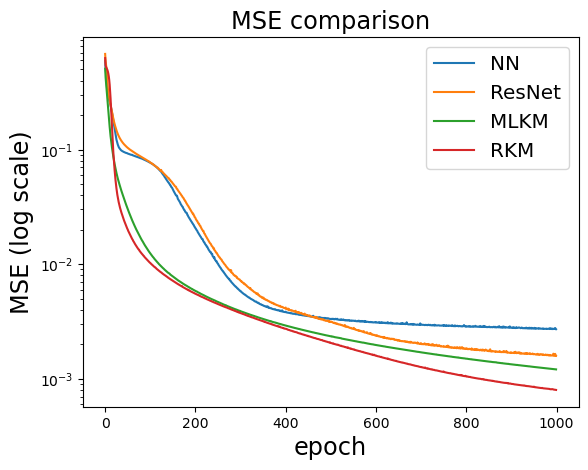

In [56]:
plt.plot(dnn_trainloss)
plt.plot(res_trainloss)
plt.plot(kernelnn_trainloss)
plt.plot(reskernel_trainloss)
plt.legend(["NN","ResNet","MLKM","RKM"],fontsize="x-large")
plt.xlabel("epoch",fontsize="xx-large")
plt.ylabel("MSE (log scale)",fontsize="xx-large")
plt.yscale("log")
plt.title("MSE comparison",fontsize="xx-large")
plt.show()

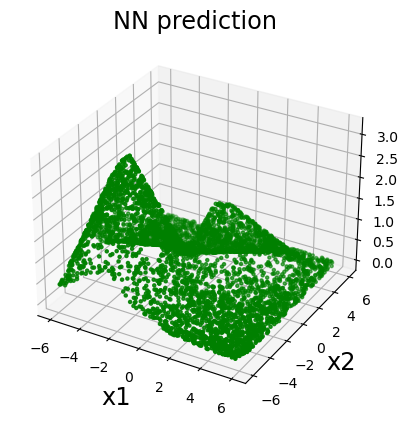

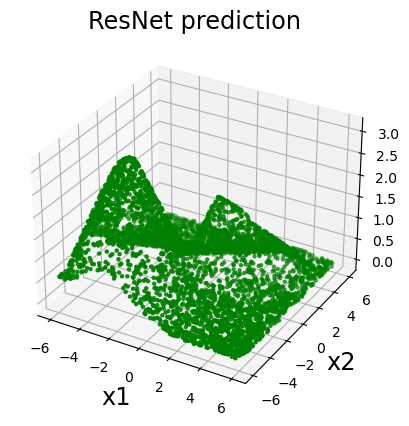

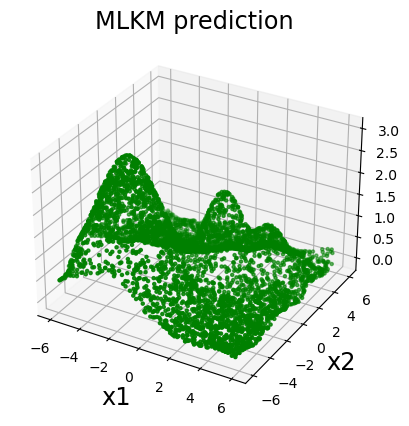

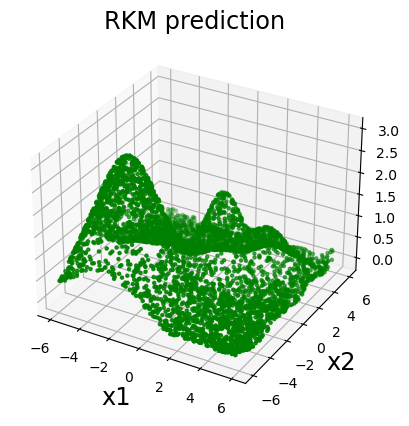

In [57]:
# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],dnn_pred,marker=".",c="green")
plt.title("NN prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()

# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],res_pred,marker=".",c="green")
plt.title("ResNet prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()

# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],kernel_pred,marker=".",c="green")
plt.title("MLKM prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()

# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],rk_pred,marker=".",c="green")
plt.title("RKM prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()

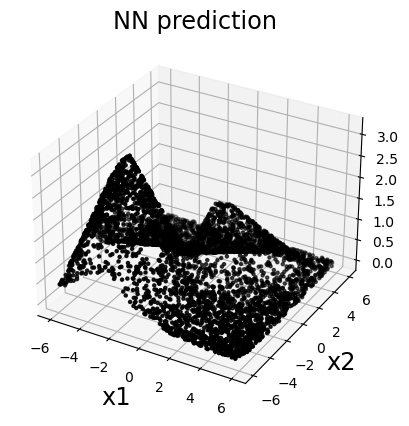

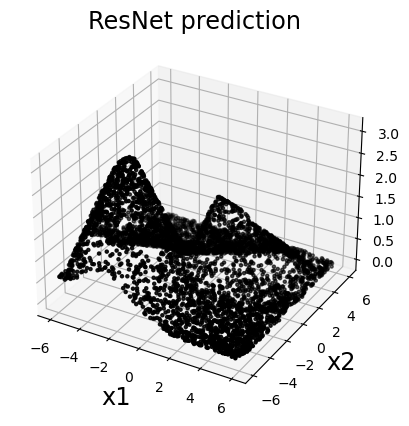

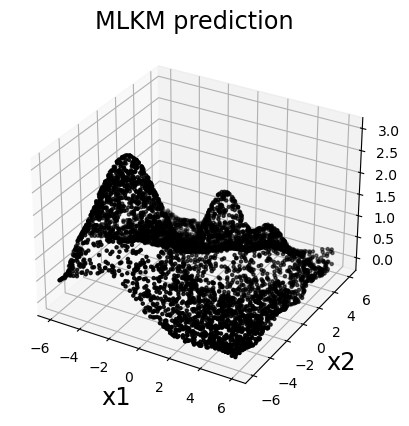

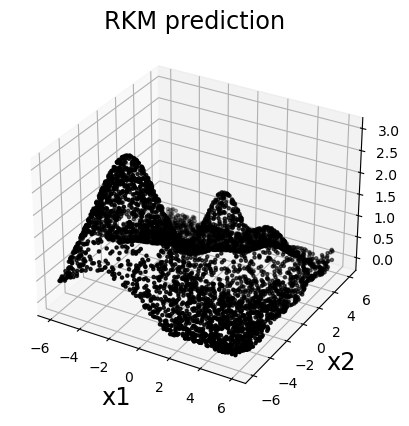

In [58]:
# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],dnn_pred,marker=".",c="black")
plt.title("NN prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()

# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],res_pred,marker=".",c="black")
plt.title("ResNet prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()

# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],kernel_pred,marker=".",c="black")
plt.title("MLKM prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()

# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],rk_pred,marker=".",c="black")
plt.title("RKM prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()